# <u>**Final Project INF574**<u>

## _Zhaoyang Chen_
## _Ribal Teeny_

#### Import Librairies

In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
import os
import copy

# Convert .off to .obj

In our project we use the star object from the TD

In [3]:
def read_off_file(input):
    vertex = []
    surface = []
    fin = open(input, 'r')
    if not fin:
        print('Fail to open the off file!')
        exit(1)

    output = input[:-3] + 'obj'
    fout = open(output, 'w')
    if not fout:
        print('Fail to open the obj file!')
        exit(1)

    content = fin.readlines()

    vertex_num, surface_num, other_num = content[1].split()
    vertex_num = int(vertex_num)
    surface_num = int(surface_num)
    for i in range(2, vertex_num + 2):
        vertex.append(content[i].split())

    for i in range(vertex_num + 2, vertex_num + surface_num + 2):
        surface.append(content[i].split())

    for i in range(vertex_num):
        fout.write('v')
        for j in range(3):
            fout.write(' ' + vertex[i][j])
        fout.write('\n')

    for i in range(surface_num):
        fout.write('f')
        fout.write(' ' + str(int(surface[i][1]) + 1) +
                   ' ' + str(int(surface[i][3]) + 1) +
                   ' ' + str(int(surface[i][2]) + 1))
        fout.write('\n')


In [4]:
starOffPath = "./data/star.off"
read_off_file(starOffPath)

# Carve Voxels

In [5]:
def xyz_spherical(xyz):
    """transform from cartesian coord to spherical"""
    x = xyz[0]
    y = xyz[1]
    z = xyz[2]
    r = np.sqrt(x**2 + y**2 + z**2)
    r_x = np.arccos(y / r)
    r_y = np.arctan2(z, x)
    return [r, r_x, r_y]


def get_rotation_matrix(r_x, r_y):
    rot_x = np.asarray([[1, 0, 0], [0, np.cos(r_x), -np.sin(r_x)],
                        [0, np.sin(r_x), np.cos(r_x)]])
    rot_y = np.asarray([[np.cos(r_y), 0, np.sin(r_y)], [0, 1, 0],
                        [-np.sin(r_y), 0, np.cos(r_y)]])
    return rot_y.dot(rot_x)


def get_extrinsic(xyz):
    rvec = xyz_spherical(xyz)
    r = get_rotation_matrix(rvec[1], rvec[2])
    t = np.asarray([0, 0, 2]).transpose()
    trans = np.eye(4)
    trans[:3, :3] = r
    trans[:3, 3] = t
    return trans


def preprocess(model):
    min_bound = model.get_min_bound()
    max_bound = model.get_max_bound()
    center = min_bound + ((max_bound - min_bound)/ 2.0)
    scale = np.linalg.norm(max_bound - min_bound) / 2.0
    vertices = np.asarray(model.vertices)
    vertices -= center
    model.vertices = o3d.utility.Vector3dVector(vertices / scale)
    return model


def voxel_carv(mesh,
                  camera_path,
                  cubic_size,
                  voxel_resolution,
                  w=300,
                  h=300,
                  use_depth=True,
                  surface_method='pointcloud'):
    mesh.compute_vertex_normals()
    camera_sphere = o3d.io.read_triangle_mesh(camera_path)

    # setup dense voxel grid
    voxel_carving = o3d.geometry.VoxelGrid.create_dense(
        width=cubic_size,
        height=cubic_size,
        depth=cubic_size,
        voxel_size=cubic_size / voxel_resolution,
        origin=[-cubic_size / 2.0, -cubic_size / 2.0, -cubic_size / 2.0],
        color=[1.0, 0.7, 0.0])

    # rescale geometry
    camera_sphere = preprocess(camera_sphere)
    mesh = preprocess(mesh)

    # setup visualizer to render depthmaps
    vis = o3d.visualization.Visualizer()
    vis.create_window(width=w, height=h, visible=False)
    vis.add_geometry(mesh)
    vis.get_render_option().mesh_show_back_face = True
    ctr = vis.get_view_control()
    param = ctr.convert_to_pinhole_camera_parameters()

    # carve voxel grid
    pcd_agg = o3d.geometry.PointCloud()
    centers_pts = np.zeros((len(camera_sphere.vertices), 3))
    for cid, xyz in enumerate(camera_sphere.vertices):
        # get new camera pose
        trans = get_extrinsic(xyz)
        param.extrinsic = trans
        c = np.linalg.inv(trans).dot(np.asarray([0, 0, 0, 1]).transpose())
        centers_pts[cid, :] = c[:3]
        ctr.convert_from_pinhole_camera_parameters(param)

        # capture depth image and make a point cloud
        vis.poll_events()
        vis.update_renderer()
        depth = vis.capture_depth_float_buffer(False)
        pcd_agg += o3d.geometry.PointCloud.create_from_depth_image(
            o3d.geometry.Image(depth),
            param.intrinsic,
            param.extrinsic,
            depth_scale=1)

        # depth map carving method
        if use_depth:
            voxel_carving.carve_depth_map(o3d.geometry.Image(depth), param)
        else:
            voxel_carving.carve_silhouette(o3d.geometry.Image(depth), param)
        print("Carve view %03d/%03d" % (cid + 1, len(camera_sphere.vertices)))
    vis.destroy_window()

    # add voxel grid survace
    print('Surface voxel grid from %s' % surface_method)
    if surface_method == 'pointcloud':
        voxel_surface = o3d.geometry.VoxelGrid.create_from_point_cloud_within_bounds(
            pcd_agg,
            voxel_size=cubic_size / voxel_resolution,
            min_bound=(-cubic_size / 2, -cubic_size / 2, -cubic_size / 2),
            max_bound=(cubic_size / 2, cubic_size / 2, cubic_size / 2))
    elif surface_method == 'mesh':
        voxel_surface = o3d.geometry.VoxelGrid.create_from_triangle_mesh_within_bounds(
            mesh,
            voxel_size=cubic_size / voxel_resolution,
            min_bound=(-cubic_size / 2, -cubic_size / 2, -cubic_size / 2),
            max_bound=(cubic_size / 2, cubic_size / 2, cubic_size / 2))
    else:
        raise Exception('invalid surface method')
    voxel_carving_surface = voxel_surface + voxel_carving

    return mesh, voxel_carving_surface, voxel_carving, voxel_surface

In [6]:
name = "star"
mesh_path = "./data/"+name+".obj"
mesh = o3d.io.read_triangle_mesh(mesh_path)
output_mesh_filename =os.path.abspath("./data/"+name+"_scaled.obj")

# Rotate object

In [7]:
rotated_mesh = mesh.get_rotation_matrix_from_xyz((np.pi / 3, 0, 0))
o3d.visualization.draw_geometries([mesh]) # visualize before rotation

mesh.rotate(rotated_mesh, center=(0, 0, 0))
o3d.visualization.draw_geometries([mesh]) # visualize after rotation

In [8]:
# save output
output_mesh_filename =os.path.abspath("./data/"+name+"_rotated.obj")
o3d.io.write_triangle_mesh(output_mesh_filename, mesh)

True

# Now voxelize

In [9]:
camera_path = os.path.abspath("./data/sphere.ply")
cubic_size = 2
voxel_resolution = 128
mesh = o3d.io.read_triangle_mesh(output_mesh_filename)

In [10]:
mesh, voxel_grid, voxel_carving, voxel_surface = voxel_carv(mesh, camera_path, cubic_size, voxel_resolution)

Carve view 001/642
Carve view 002/642
Carve view 003/642
Carve view 004/642
Carve view 005/642
Carve view 006/642
Carve view 007/642
Carve view 008/642
Carve view 009/642
Carve view 010/642
Carve view 011/642
Carve view 012/642
Carve view 013/642
Carve view 014/642
Carve view 015/642
Carve view 016/642
Carve view 017/642
Carve view 018/642
Carve view 019/642
Carve view 020/642
Carve view 021/642
Carve view 022/642
Carve view 023/642
Carve view 024/642
Carve view 025/642
Carve view 026/642
Carve view 027/642
Carve view 028/642
Carve view 029/642
Carve view 030/642
Carve view 031/642
Carve view 032/642
Carve view 033/642
Carve view 034/642
Carve view 035/642
Carve view 036/642
Carve view 037/642
Carve view 038/642
Carve view 039/642
Carve view 040/642
Carve view 041/642
Carve view 042/642
Carve view 043/642
Carve view 044/642
Carve view 045/642
Carve view 046/642
Carve view 047/642
Carve view 048/642
Carve view 049/642
Carve view 050/642
Carve view 051/642
Carve view 052/642
Carve view 0

Carve view 437/642
Carve view 438/642
Carve view 439/642
Carve view 440/642
Carve view 441/642
Carve view 442/642
Carve view 443/642
Carve view 444/642
Carve view 445/642
Carve view 446/642
Carve view 447/642
Carve view 448/642
Carve view 449/642
Carve view 450/642
Carve view 451/642
Carve view 452/642
Carve view 453/642
Carve view 454/642
Carve view 455/642
Carve view 456/642
Carve view 457/642
Carve view 458/642
Carve view 459/642
Carve view 460/642
Carve view 461/642
Carve view 462/642
Carve view 463/642
Carve view 464/642
Carve view 465/642
Carve view 466/642
Carve view 467/642
Carve view 468/642
Carve view 469/642
Carve view 470/642
Carve view 471/642
Carve view 472/642
Carve view 473/642
Carve view 474/642
Carve view 475/642
Carve view 476/642
Carve view 477/642
Carve view 478/642
Carve view 479/642
Carve view 480/642
Carve view 481/642
Carve view 482/642
Carve view 483/642
Carve view 484/642
Carve view 485/642
Carve view 486/642
Carve view 487/642
Carve view 488/642
Carve view 4

In [11]:
output_voxel_filename = os.path.abspath("./data/"+name+"_voxelized.ply")
# save output
o3d.io.write_voxel_grid(output_voxel_filename, voxel_grid, print_progress=True)
o3d.io.write_triangle_mesh(output_mesh_filename, mesh, print_progress=True)

[Open3D WARNING] Write OBJ can not include triangle normals.


True

In [12]:
o3d.visualization.draw_geometries([voxel_surface])

In [13]:
o3d.visualization.draw_geometries([voxel_carving])

In [14]:
o3d.visualization.draw_geometries([voxel_grid])

# Voxel preprocessing

In [15]:
def get_barycenter(voxels_np):
    """
    Input: A numpy array (full) with the information whether the voxel is contained
    Output: The grid coordinates of the center of mass
    """
    grid_shape = voxels_np.shape
    counter = 0
    center = np.array([0.,0.,0.])
    for id_x in range(grid_shape[0]):
        for id_y in range(grid_shape[1]):
            for id_z in range(grid_shape[2]):
                #check whether we hit a a voxel in the mesh
                if(voxels_np[id_x,id_y,id_z]==1):
                    counter+=1
                    center = (1/float(counter))*np.array([float(id_x),float(id_y),float(id_z)]) + (float(counter-1)/float(counter))*center

    result = ([int(center[0]),int(center[1]),int(center[2])])
    return result

In [16]:
def voxel_to_numpy(voxels, voxel_resolution = 64):
    """
    Input: An instance if the open3d voxelgrid datastructure, the number of voxels per sidelength (voxel_resolution)
    Output: A numpy array of voxel_resolution x voxel_resolution x voxel_resolution with 1 and 0, where ever we have a voxel or not 
    """
    vx_numpy = np.zeros((voxel_resolution,voxel_resolution,voxel_resolution))
    grid = voxels.get_voxels()
    for i in grid: # index is from 1 to scale/size
        voxel_index = i.grid_index #a[0] a[1] a[2]
        vx_numpy[voxel_index[0]-1,voxel_index[1]-1,voxel_index[2]-1] = 1
    return vx_numpy

def voxel_surface_numpy(voxels_np):
    """
    Input: 
        voxels: An N x N x N numpy array that indicates the voxel indices of a filled mesh. 
                The values \in \{0,1\}
        thickness: the number of cubes, that should be the thickness of the boundary the voxel grid

    Output: 
        voxels_surface_np, voxels_interior_np . Two numpy arrays that have the same shape as voxels_np. The first one contains the voxels, that are in the surface, the second one contains the voxels, that are in the interior.
        In theory the sum of these two arrays should yield the input array again
    """
    grid_shape = voxels_np.shape
    voxels_int = copy.deepcopy(voxels_np)
    voxel_surface = np.zeros_like(voxels_np)
    #somehow a sparse representation would be good
    #build the sum of the 6 values in the neighborhood of the point (x,y,z)
    sum_nbh = lambda x,y,z,A: A[x+1,y,z] +A[x-1,y,z] +A[x,y+1,z] +A[x,y-1,z] + A[x,y,z+1] + A[x,y,z-1] 
    for id_x in range(grid_shape[0]):
        for id_y in range(grid_shape[1]):
            for id_z in range(grid_shape[2]):
                #check whether we hit a a voxel in the mesh
                if(voxels_np[id_x,id_y,id_z]==1):
                    sum_neighboring_values = sum_nbh(id_x,id_y,id_z, voxels_np)
                    #print('cds', id_x,id_y,id_z)
                    #print('sum neighbh', sum_neighboring_values)
                    if(sum_neighboring_values<6):
                        voxels_int[id_x,id_y,id_z] = 0
                        voxel_surface[id_x,id_y,id_z] = 1

    return voxels_int, voxel_surface

def voxel_carv_preprocess_numpy(voxels_np, thickness = 2):
    """
    Input: 
        voxels: An N x N x N numpy array that indicates the voxel indices of a filled mesh. 
                The values \in \{0,1\}
        thickness: the number of cubes, that should be the thickness of the boundary the voxel grid

    Output: 
        voxels_surface_np, voxels_interior_np . Two numpy arrays that have the same shape as voxels_np. The first one contains the voxels, that are in the surface, the second one contains the voxels, that are in the interior.
        In theory the sum of these two arrays should yield the input array again
    """
    boundary = np.zeros_like(voxels_np)
    interior, surface = voxel_surface_numpy(voxels_np)
    boundary +=surface
    for steps in range(thickness-1):
        interior, surface = voxel_surface_numpy(interior)
        boundary+=surface
    return interior, boundary


In [17]:
voxel_matrix = voxel_to_numpy(voxel_grid, voxel_resolution=int(voxel_resolution))
inside, surface = voxel_carv_preprocess_numpy(voxel_matrix, thickness=1)

In [18]:
# save numpy
np.save(file="./data/"+name+"_voxel_surface",arr=np.array(surface, dtype=bool))
np.save(file="./data/"+name+"_voxel_int",arr=np.array(inside, dtype=bool))

# Visualize Voxel

In [19]:
npSurface = np.load("./data/star_voxel_surface.npy")
npInterior = np.load("./data/star_voxel_int.npy")

In [20]:
voxels = npInterior | npSurface
colors = np.empty(voxels.shape, dtype=object)
colors[npSurface] = 'red'
colors[npInterior] = 'yellow'

<IPython.core.display.Javascript object>


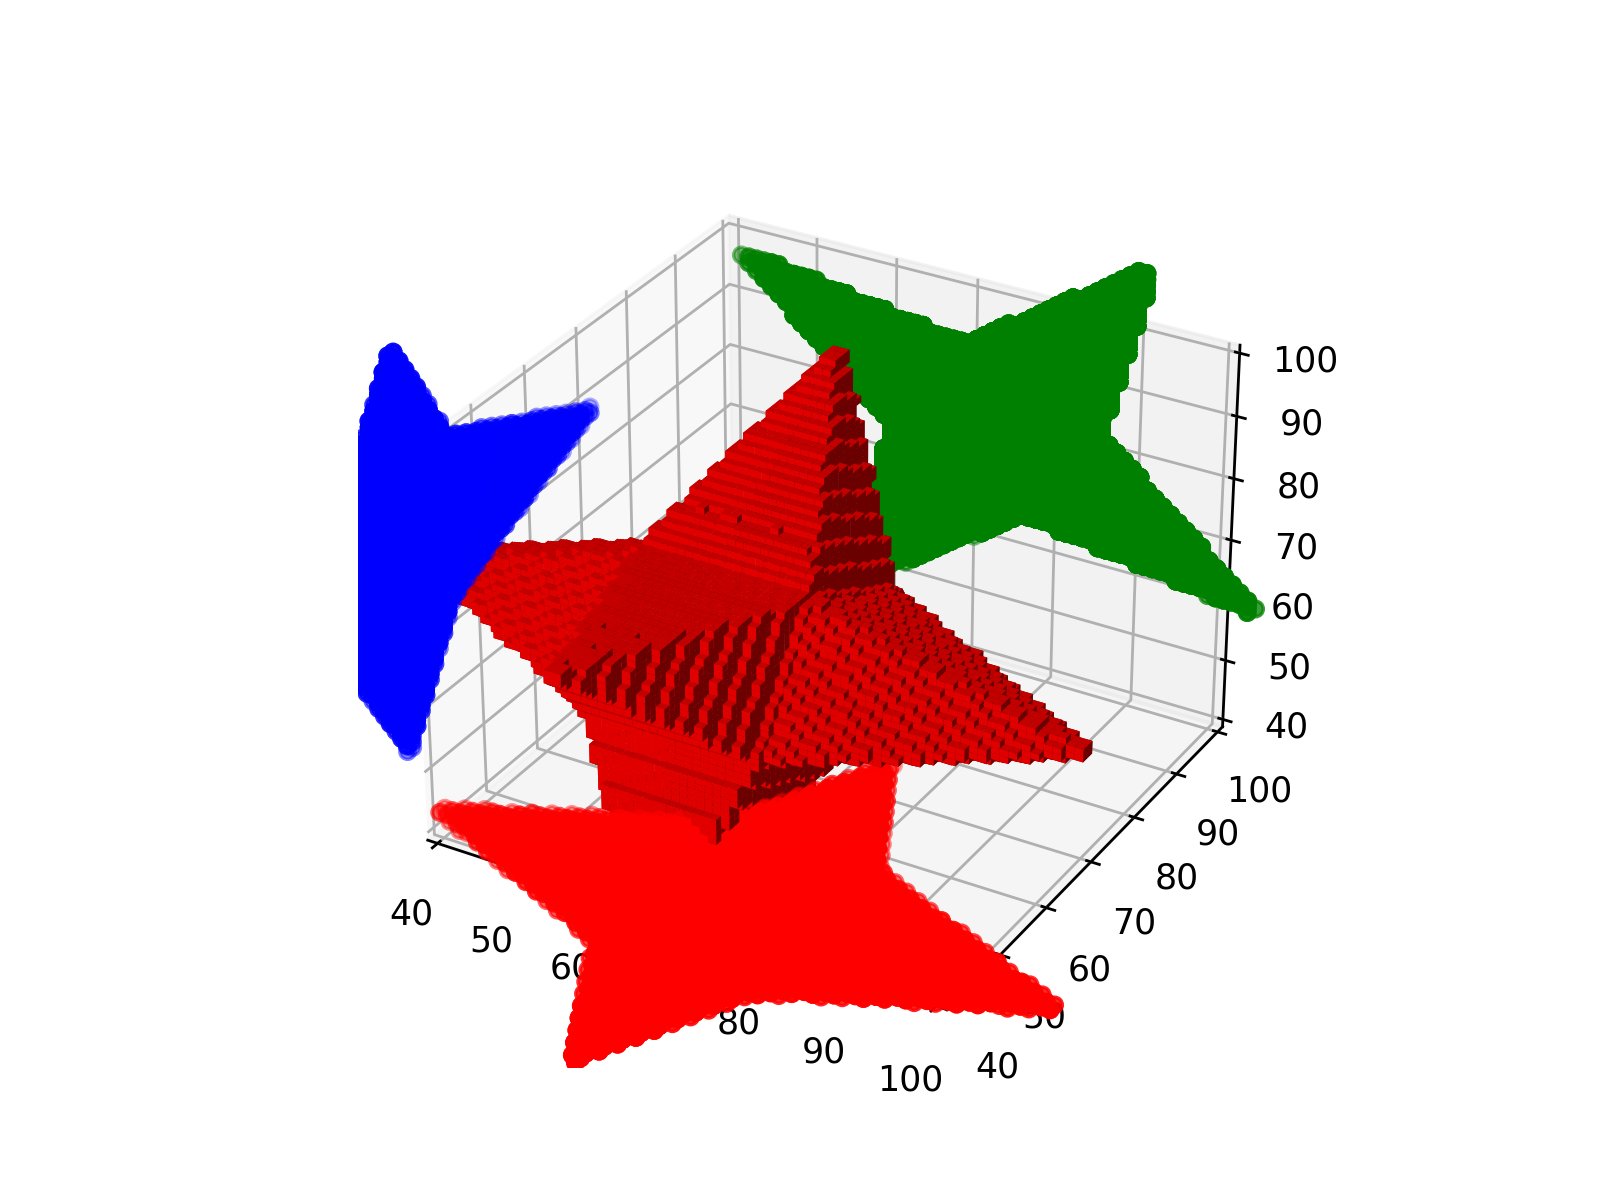

In [21]:
ax = plt.figure().add_subplot(projection='3d')
ax.set(xlim=(40,100), ylim=(40,100), zlim=(40,100))
# projected interior of object on every dimension
X,Y,Z = np.nonzero(inside)
ax.scatter(X, Y, zdir='z', zs = 20, c = 'r')
ax.scatter(Y, Z, zdir='y', zs = 120, c = 'g')
ax.scatter(X, Z, zdir='x', zs = 20, c = 'b')

# plot object
ax.voxels(voxels,facecolors = colors)
plt.show()

**Plot of voxels representing the object and the 3 projections of the inside**

**In case you don't see the results please give it some time as matplotlib is slow in plotting in 3d specially when dealing with voxels**

# Carving

In [22]:
def get_support_base(voxels_np):
    """
    Input: A numpy array (full) with the information whether the voxel is contained
    Output: the range of support base
    NOTE: The z axis is perpendicular to the support base. 
          The support base is close to z=0
    """
    grid_shape = voxels_np.shape
    for id_z in range(grid_shape[2]):
        if(np.count_nonzero(voxels_np[:,:,id_z]==True)>0):
            support_base = voxels_np[:,:,id_z]
            support_index = np.nonzero(support_base)
            max_x = np.max(support_index[0])
            min_x = np.min(support_index[0])
            max_y = np.max(support_index[1])
            min_y = np.min(support_index[1])
            center = np.array([int((max_x+min_x)/2), int((min_y+max_y)/2)])
            scaled_support_base = np.full((grid_shape[0],grid_shape[1]),False)
            
            #Here we manually set the size for the support base
            #This is chosen purely from intuition and it is possible that there are better choices.
            scaled_support_base[center[0]-1:center[0]+1,center[1]:center[1]+1] = True
            if((np.logical_and(scaled_support_base,support_base)==scaled_support_base).all()):               
                return scaled_support_base

def get_support_base2(voxels):
    x_min = np.min(np.nonzero(voxels)[0])
    x_max = np.max(np.nonzero(voxels)[0])
    y_min = np.min(np.nonzero(voxels)[1])
    y_max = np.max(np.nonzero(voxels)[1])
    z_min = np.min(np.nonzero(voxels)[2])

    # Create a new numpy array for the support base
    base_plane = np.zeros(voxels.shape)

    # Set the voxels in the support base to 1
    base_plane[x_min:x_max, y_min:y_max, z_min] = 1
    base_voxels = np.logical_and(voxels,base_plane)
    
    return base_voxels

def carving(voxel_surface,voxel_inside,support_base):
    grid_shape = voxel_surface.shape
    carved_voxel_inside = np.copy(voxel_inside)
    support_index = np.nonzero(support_base)
    max_x = np.max(support_index[0])
    min_x = np.min(support_index[0])
    max_y = np.max(support_index[1])
    min_y = np.min(support_index[1])
    barycenter = get_barycenter(voxel_surface + voxel_inside)
    print("barycenter", barycenter)
    barycenter_x = barycenter[0]
    barycenter_y = barycenter[1]
    print("Support base:\n   max x %d, min x %d,\n   max y %d, min y %d" %(max_x,min_x,max_y,min_y))
    

    if (min_x <= barycenter_x <= max_x) and (min_y <= barycenter_y <= max_y): # model already stable
        return carved_voxel_inside

    if barycenter_x < min_x:  
        print('barycenter_x < min_x')
        # identify where to start
        for i in range(grid_shape[0]): # cut y-z plane
            if not carved_voxel_inside[i, :, :].any():
                continue
            else:
                carve_x = i
                break
        # start carving
        while barycenter_x < min_x and carve_x < grid_shape[0]:
            if barycenter_x < min_x:
                print("Carving X = %d" % carve_x)
                carved_voxel_inside[carve_x, :, :] = False
                carve_x += 1
            else:
                print('failure x')
                break
            barycenter = get_barycenter(carved_voxel_inside)
            barycenter_x = barycenter[0]
            barycenter_y = barycenter[2]

    if barycenter_x > max_x:
        print('barycenter_x > max_x')
        carve_x = grid_shape[0] - 1
        for i in range(grid_shape[0]):
            if not carved_voxel_inside[grid_shape[0] - i - 1, :, :].any():
                continue
            else:
                carve_x = grid_shape[0] - i - 1
                break

        while barycenter_x > max_x and carve_x >= 0:
            if barycenter_x > max_x:
                print("Carving X = %d" % carve_x)
                carved_voxel_inside[carve_x, :, :] = False
                carve_x -= 1
            else:
                print('failure x')
                break
            barycenter = get_barycenter(carved_voxel_inside)
            barycenter_x = barycenter[0]
            barycenter_y = barycenter[1]

    if barycenter_y < min_y:  # cut x-z plane
        print('barycenter_y < min_y')
        for i in range(grid_shape[1]):
            if not carved_voxel_inside[:, i, :].any():
                continue
            else:
                carve_y = i
                break

        while barycenter_y < min_y and carve_y < grid_shape[2]:
            if barycenter_y < min_y:
                print("Carving Y = %d" % carve_y)
                carved_voxel_inside[:, carve_y, :] = False
                print(np.count_nonzero(carved_voxel_inside[:, :, :] == True))
                carve_y += 1
            else:
                print('failure y')
                break
            barycenter = get_barycenter(carved_voxel_inside)
            barycenter_x = barycenter[0]
            barycenter_y = barycenter[1]
            print(barycenter)
            print(barycenter_y, min_y)

    if barycenter_y > max_y:
        print('barycenter_y > max_y')
        for i in range(grid_shape[1]):
            if not carved_voxel_inside[:, grid_shape[1] - i - 1, :].any():
                continue
            else:
                carve_y = grid_shape[2] - i - 1
                break
                
        while barycenter_y > max_y and carve_y >= 0:
            if barycenter_y > max_y:
                print("Carving Y = %d" % carve_y)
                carved_voxel_inside[:, carve_y, :] = False
                carve_y -= 1
            else:
                print('failure y')
                break
            barycenter = get_barycenter(carved_voxel_inside)
            barycenter_x = barycenter[0]
            barycenter_y = barycenter[1]

    if (min_x <= barycenter_x <= max_x) and (min_y <= barycenter_y <= max_y):
        print("Carving Done!\n The new barycenter is in the support base!")
    return carved_voxel_inside

In [23]:
scaled_support_base = get_support_base2(voxels)
carved_voxel_inside = carving(npSurface,npInterior,scaled_support_base)
voxels_carved = npSurface + carved_voxel_inside

barycenter [62, 62, 62]
Support base:
   max x 63, min x 62,
   max y 43, min y 42
barycenter_y > max_y
Carving Y = 96
Carving Y = 95
Carving Y = 94
Carving Y = 93
Carving Y = 92
Carving Y = 91
Carving Y = 90
Carving Y = 89
Carving Y = 88
Carving Y = 87
Carving Y = 86
Carving Y = 85
Carving Y = 84
Carving Y = 83
Carving Y = 82
Carving Y = 81
Carving Y = 80
Carving Y = 79
Carving Y = 78
Carving Y = 77
Carving Y = 76
Carving Y = 75
Carving Y = 74
Carving Y = 73
Carving Y = 72
Carving Y = 71
Carving Y = 70
Carving Y = 69
Carving Y = 68
Carving Y = 67
Carving Y = 66
Carving Y = 65
Carving Y = 64
Carving Y = 63
Carving Y = 62
Carving Y = 61
Carving Y = 60
Carving Y = 59
Carving Y = 58
Carving Y = 57
Carving Y = 56
Carving Y = 55
Carving Y = 54
Carving Y = 53
Carving Y = 52
Carving Y = 51
Carving Y = 50
Carving Y = 49
Carving Y = 48
Carving Done!
 The new barycenter is in the support base!


In [24]:
# save results
np.save(file="./data/"+name+"_voxel_int_carved",arr=np.array(carved_voxel_inside, dtype=bool))
np.save(file="./data/"+name+"_voxel_entire_carved",arr=np.array(voxels_carved, dtype=bool))

# Visualize Results

In [25]:
x,y,z = np.nonzero(scaled_support_base)
colors = np.empty(voxels.shape, dtype=object)
colors[carved_voxel_inside] = 'green'
colors[voxels_carved] = 'blue'

<IPython.core.display.Javascript object>


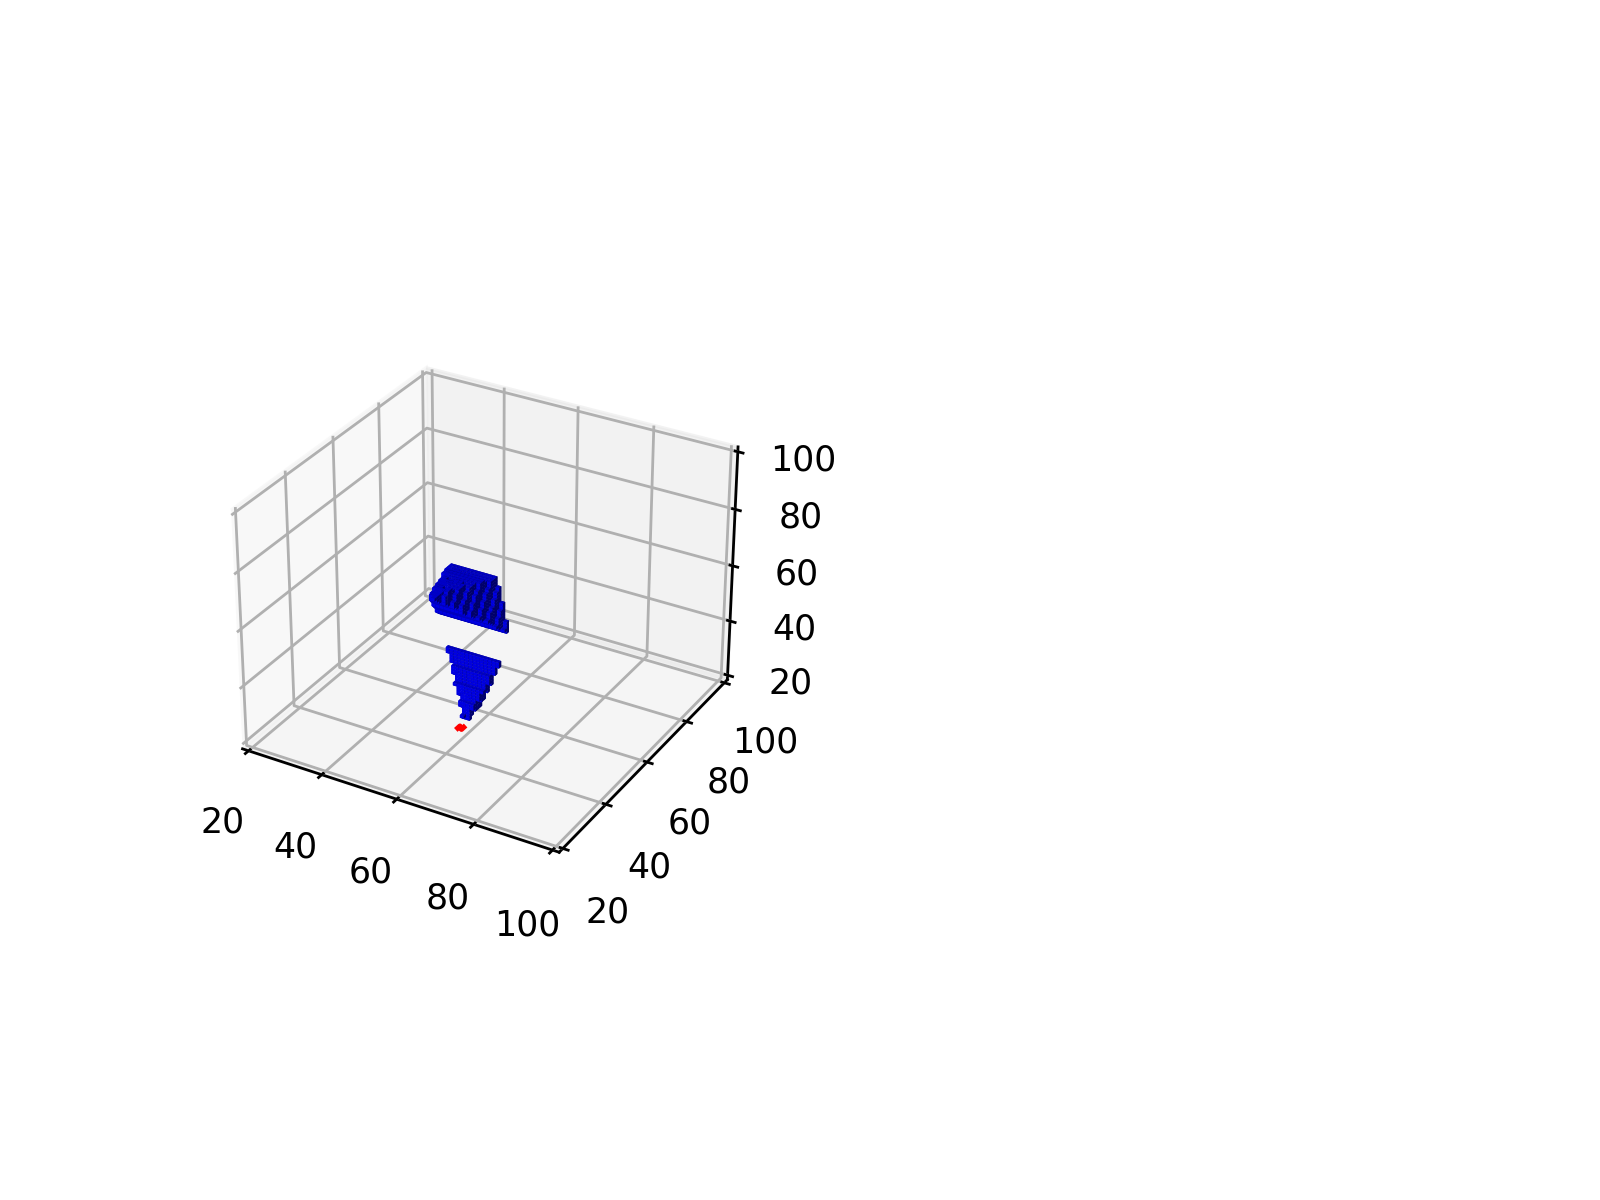

<IPython.core.display.Javascript object>


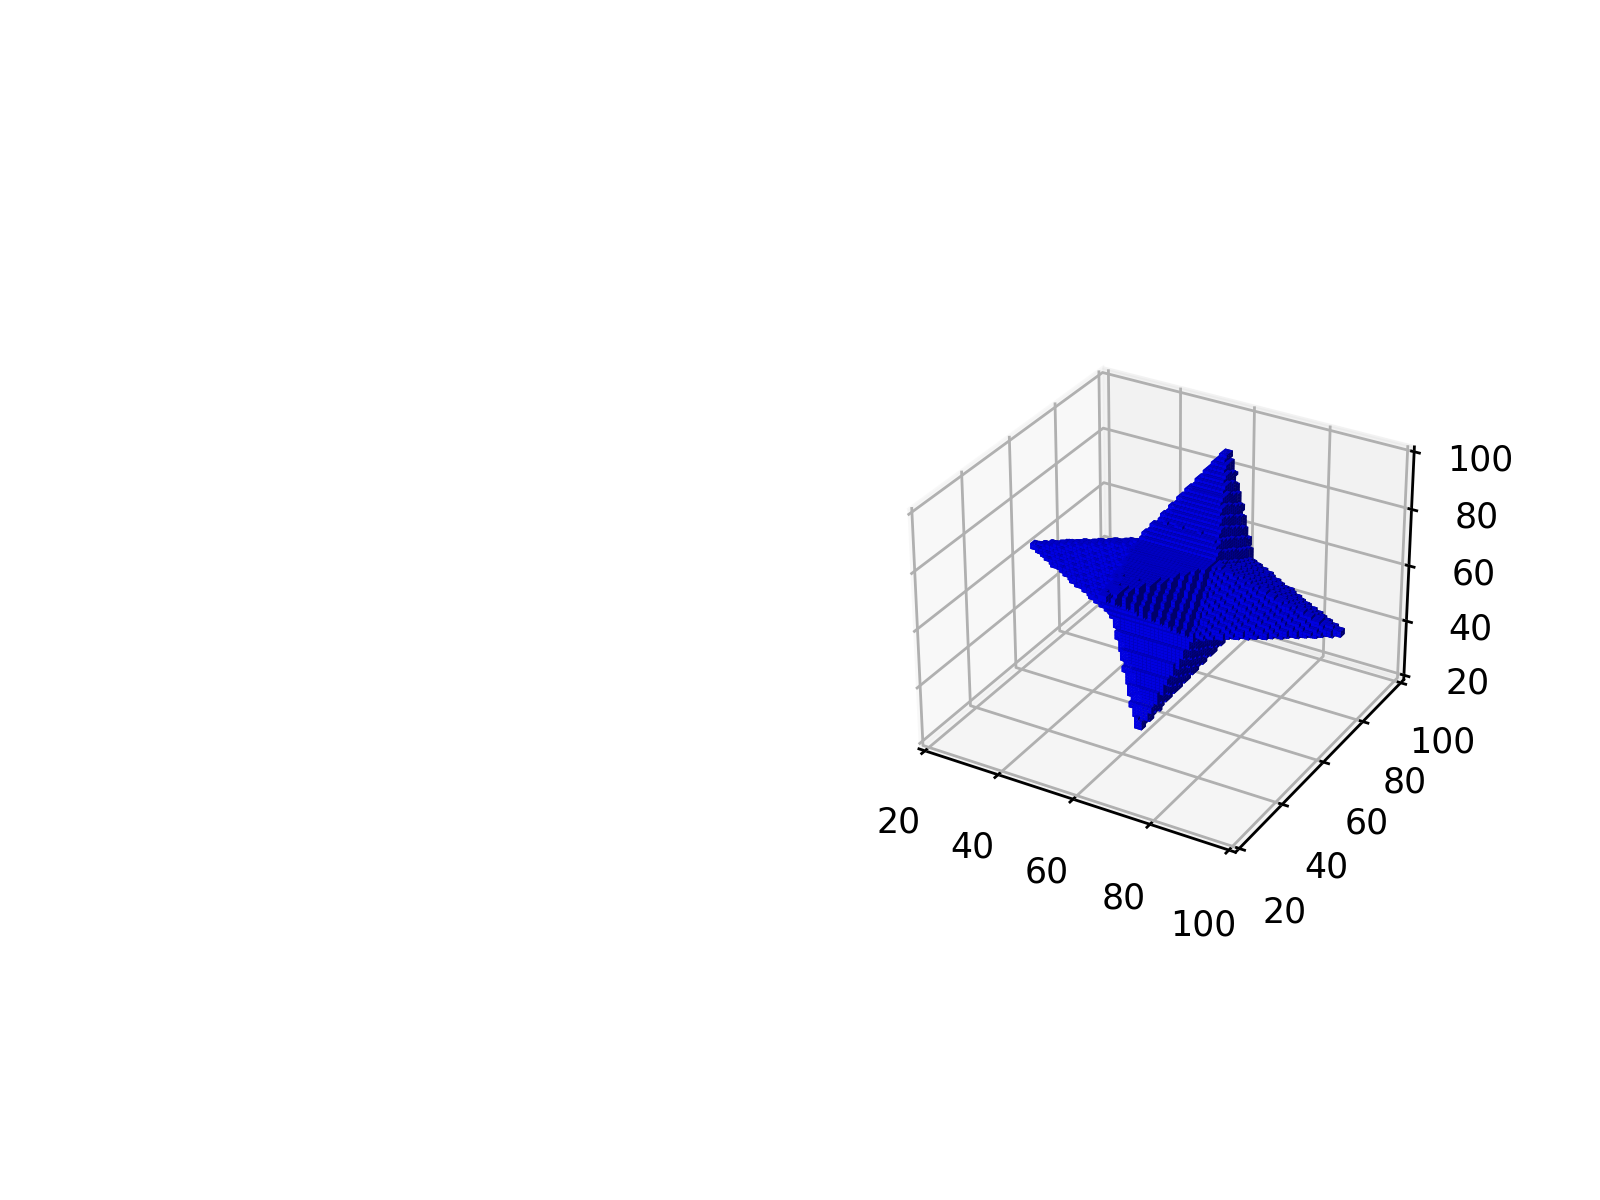

In [26]:
ax1 = plt.figure().add_subplot(121, projection='3d')
ax1.voxels(carved_voxel_inside, facecolors=colors)
ax1.plot3D(x, y, z, 'red') # plot support base
ax1.set(xlim=(20,100), ylim=(20,100), zlim=(20,100))

ax2 = plt.figure().add_subplot(122, projection='3d')
ax2.voxels(voxels_carved, facecolors=colors)
ax2.set(xlim=(20,100), ylim=(20,100), zlim=(20,100))
plt.show()